# Cats vs. dogs dataset with TF/keras

## 1. Load the data
- download, unzip and load the data
- visualize a sample

## 2. Use `ImageDataGenerator` to prepare the dataset for the model

## 3. Create a model and train

Source: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [71]:
from ml_helpers.scraping import *
from ml_helpers.image import *
from ml_helpers.tf import *

## 1. Load the data
 
For this kaggle competition, i have 2 zip folders - training and testing data. I'll leave training data as it is and randomly select some percentage of training data to use as my validation dataset.

I need to create a separate validation folder for it, so that I can use ImageGenerator for automatic labeling

In [8]:
PATH = "data\\dogs-vs-cats"
!dir $PATH

 Volume in drive C has no label.
 Volume Serial Number is 6667-65AE

 Directory of C:\workspace\data-science-portfolio\data\dogs-vs-cats

03/08/2019  14:33    <DIR>          .
03/08/2019  14:33    <DIR>          ..
03/08/2019  14:06            88,903 sampleSubmission.csv
20/09/2013  10:19    <DIR>          test
03/08/2019  14:08       284,321,224 test1.zip
20/09/2013  10:12    <DIR>          train
03/08/2019  14:11       569,546,721 train.zip
               3 File(s)    853,956,848 bytes
               4 Dir(s)  257,010,339,840 bytes free


In [26]:
data_dir_train = PATH + "\\train"
data_dir_valid = PATH + "\\valid"

In [18]:
cat_filenames = find_files_in_dir(data_dir_train, "cat")
dog_filenames = find_files_in_dir(data_dir_train, "dog")

len(cat_filenames), cat_filenames[:5]

(12500,
 ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg'])

In [23]:
full_cat_path = [os.path.join(data_dir_train, f) for f in cat_filenames]
full_dog_path = [os.path.join(data_dir_train, f) for f in dog_filenames]

move_files_to_dir(data_dir_train + "\\cats", full_cat_path)
move_files_to_dir(data_dir_train + "\\dogs", full_dog_path)

Creating the validation dataset
- training data is balanced, let's keep it that way in the validation dataset
- i can randomly sample, the validation data doesn't have to be consequential (e.g. there is no time-series component)

In [48]:
n_cats = 12500
n_dogs = 12500

n_valid = int(12500 * 0.1)
# Sampling with replacement
indices = np.random.choice(range(n_cats), n_valid, replace=False)

cat_filenames = find_files_in_dir(data_dir_train + "\\cats")
dog_filenames = find_files_in_dir(data_dir_train + "\\dogs")

valid_cats = [cat_filenames[i] for i in indices]
valid_dogs = [dog_filenames[i] for i in indices]

assert len(valid_cats) == n_valid

In [49]:
full_cat_path = [os.path.join(data_dir_train + "\\cats", f) for f in valid_cats]
full_dog_path = [os.path.join(data_dir_train + "\\dogs", f) for f in valid_dogs]

assert len(full_cat_path) == len(full_dog_path) == n_valid

move_files_to_dir(data_dir_valid + "\\cats", full_cat_path)
move_files_to_dir(data_dir_valid + "\\dogs", full_dog_path)

In [50]:
assert len(find_files_in_dir(data_dir_valid + "\\cats")) == len(find_files_in_dir(data_dir_valid + "\\dogs")) == n_valid

Load a random image

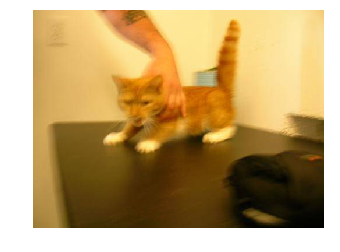

In [51]:
random_img = load_image_from_path(f"{data_dir_train}\\cats\\{cat_filenames[0]}")
import matplotlib.pyplot as plt
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(random_img)
plt.show()

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rescale=1/255)
train_gen = gen.flow_from_directory(
    data_dir_train, target_size=(150,150), batch_size=128, class_mode='binary')

valid_gen = gen.flow_from_directory(
    data_dir_valid, target_size=(150,150), batch_size=128, class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## 3. Create a model and train

In [55]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 64)        36928     
__________

In [56]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

%time history = model.fit_generator(\
    train_gen, validation_data=valid_gen, steps_per_epoch=8, epochs=15, validation_steps=8, verbose=1)

Epoch 1/15
176/176 [==============================] - 347s 2s/step - loss: 0.6700 - acc: 0.5912 - val_loss: 1.5216 - val_acc: 0.5048
Epoch 2/15
176/176 [==============================] - 303s 2s/step - loss: 0.6061 - acc: 0.6764 - val_loss: 0.5593 - val_acc: 0.7000
Epoch 3/15
176/176 [==============================] - 322s 2s/step - loss: 0.5391 - acc: 0.7306 - val_loss: 0.5529 - val_acc: 0.7044
Epoch 4/15
176/176 [==============================] - 306s 2s/step - loss: 0.4824 - acc: 0.7664 - val_loss: 0.4774 - val_acc: 0.7624
Epoch 5/15
176/176 [==============================] - 327s 2s/step - loss: 0.4348 - acc: 0.7987 - val_loss: 0.4289 - val_acc: 0.8020
Epoch 6/15
176/176 [==============================] - 317s 2s/step - loss: 0.3925 - acc: 0.8203 - val_loss: 0.3875 - val_acc: 0.8312
Epoch 7/15
176/176 [==============================] - 303s 2s/step - loss: 0.3525 - acc: 0.8453 - val_loss: 0.4079 - val_acc: 0.8124
Epoch 8/15
176/176 [==============================] - 359s 2s/step - 

In [61]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
random_cat = load_img(os.path.join(data_dir_train + "\\cats", find_files_in_dir(data_dir_train + "\\cats")[42]), target_size=(150, 150))
x = img_to_array(random_cat)
x = x.reshape((1,) + x.shape)
x /= 255.0

In [62]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

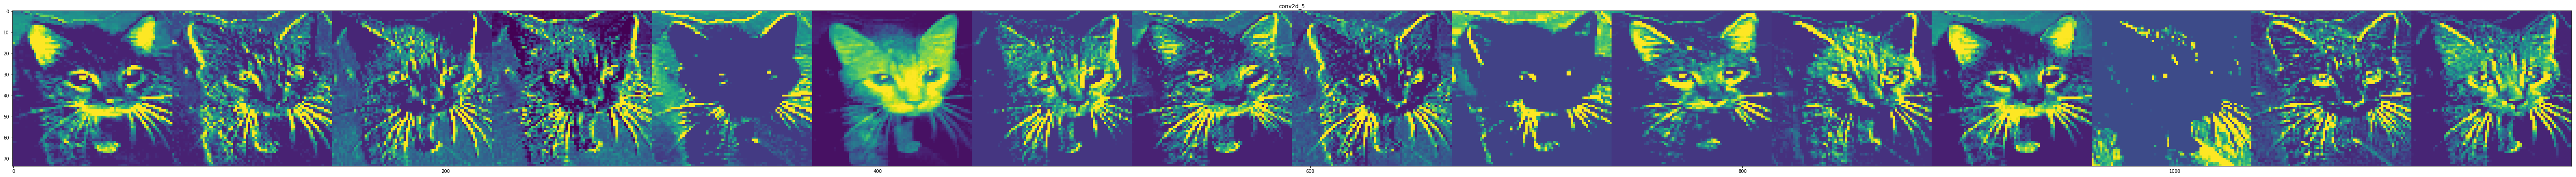

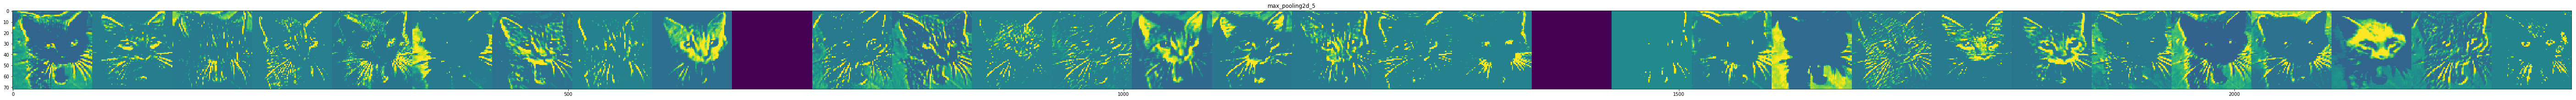

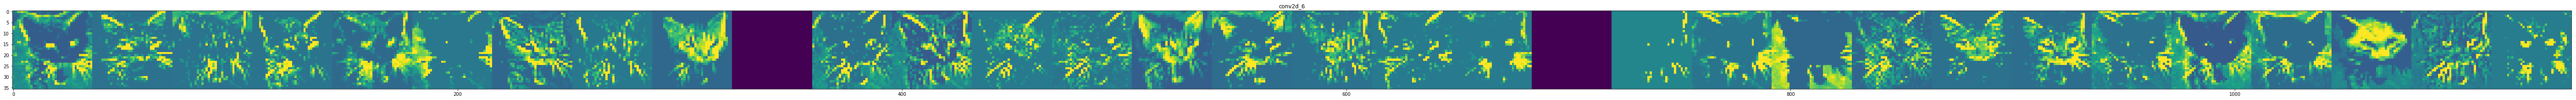

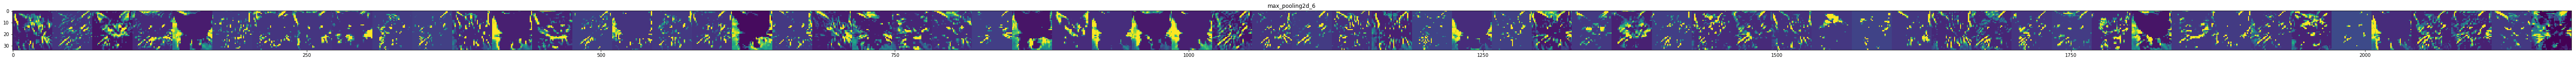

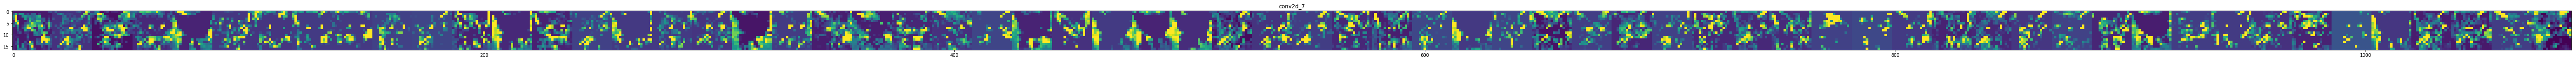

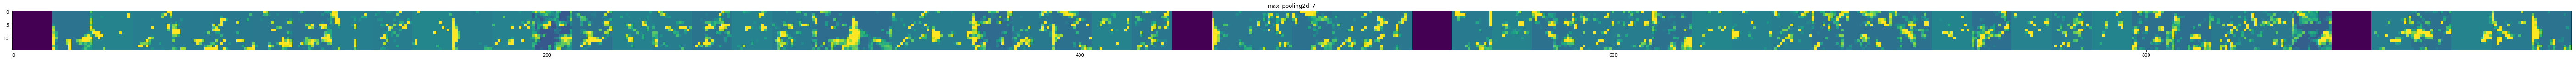

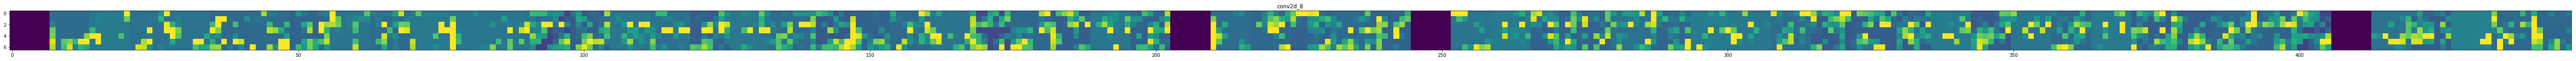

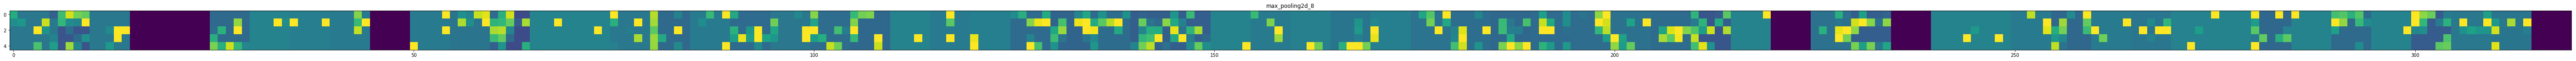

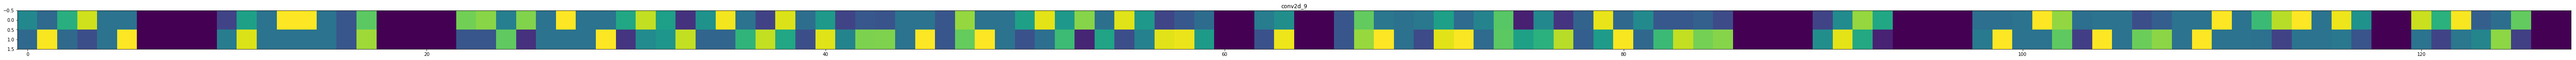

In [72]:
visualize_activations(successive_feature_maps, layer_names)

 we go from the raw pixels of the images to increasingly abstract and compact representations.

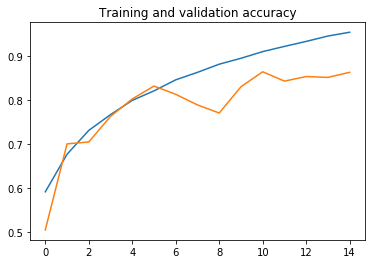

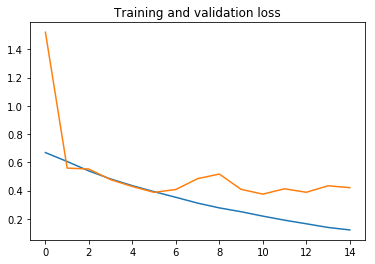

In [74]:
epochs = range(len(history.history['acc' ]))
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('Training and validation accuracy')
plt.show()

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('Training and validation loss')
plt.show()

In [88]:
VAL_PATH = PATH + "\\test\\"
from tensorflow.keras.preprocessing import image
 
image_names = ["5.jpg", "6606.jpg"]
images = []
predictions = []
for img_name in image_names:
    img = image.load_img(f"{VAL_PATH}{img_name}", target_size=(150,150))
    images.append(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    classes = model.predict(x, batch_size=10)
    predictions.append("dog" if classes[0] > 0 else "cat")

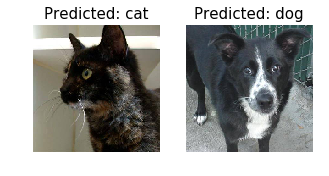

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(5,5))

for idx, ax_ in enumerate(ax):
    ax_.grid(False)
    ax_.imshow(images[idx])
    ax_.set_title(f"Predicted: {predictions[idx]}", fontsize=15)
    ax_.axis('off')
plt.show()